In [1]:
# packages
! pip install numpy
! pip install pandas
! pip install matplotlib
! pip install scikit-learn
! pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 53.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 KB 5.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 36.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 27.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 2.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.2 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.0/769.0 KB 12.2 MB/s eta 0:00:0000:01


In [2]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to /home/ucloud/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ucloud/nltk_data...


In [3]:
os.getcwd()

'/work/project/src'

Make sure to be in the ```src``` folder to run the code, because the paths are set accordingly.

## Looking at stop words
I download the stop words from nltk and choose the relevant ones for my own stop word corpus. The literature suggests that pronouns and verbs in past tense are indicators depression, so I choose to leave them in the data.

In [4]:
stop_corpus = stopwords.words('english')
print(stop_corpus)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Preprocessing
This prepocessing function removes unwanted characters from the data and is initiated in the load_processing_data() function below.

In [26]:
def text_preprocessing(s):
    # lowercase the sentence
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r'\'t', ' not', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

I created a separate stop word function because the model performs worse when stop words are removed. Therefore, it is easy to uncomment two lines of code to see how it performs without stop words, but I have chosen to keep them in my analysis.

In [6]:
def stop_words(s):
    # remove stop words
    s = ' '.join([word for word in s.split()
                  if word not in stop_corpus])
    
    return s

# Machine learning

## Load and process the data

This function preprocesses the data and creates the train and test split

In [7]:
# let's load and process the data 
def load_process_data():
    # define path
    filepath = os.path.join('../in/depression_dataset_reddit_cleaned.csv')
    # read data as pandas data frame
    data = pd.read_csv(filepath)

    # a bit of data exploration
    print('') # for a bit of space
    
    depression = data[data['is_depression'] == 1]
    non_depression = data[data['is_depression'] == 0]
    print(round(depression['clean_text'].str.split(" ").apply(len).describe()))
    
    print('') # for a bit of space
    
    print(round(non_depression['clean_text'].str.split(" ").apply(len).describe()))

    # create train test split
    X_train, X_test, y_train, y_test = train_test_split(data['clean_text'], # texts for the model
                                                            data['is_depression'], # classification labels
                                                            test_size = 0.2, # create an 80/20 split
                                                            random_state = 42) # random state for reproducibility
    X_train = np.array([text_preprocessing(text) for text in X_train])
    X_test = np.array([text_preprocessing(text) for text in X_test])

    # uncomment the two lines below here to see how the model performs with stop words removed
    #X_train = np.array([stop_words(text) for text in X_train])
    #X_test = np.array([stop_words(text) for text in X_test])

    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = load_process_data()


count    3831.0
mean      136.0
std       186.0
min         1.0
25%        32.0
50%        78.0
75%       174.0
max      4239.0
Name: clean_text, dtype: float64

count    3900.0
mean       14.0
std         7.0
min         1.0
25%         8.0
50%        13.0
75%        20.0
max        42.0
Name: clean_text, dtype: float64


There are 3831 posts with the label depression, the mean length is 136 words, and the max is 4239.

There are 3900 posts with the label non-depression, the mean length is 14 words, and the max is 42.

### Vectorizer

This function tdidf vectorizes the data set.

In [9]:
# create vectorizer
def vec(X_train, X_test):
    # initialize vectorizer
    vectorizer = TfidfVectorizer(lowercase = True, min_df = 0.05, max_df = 0.95)
    # fit and transform the data to the vectorizer
    X_train_feats = vectorizer.fit_transform(X_train)
    X_test_feats = vectorizer.transform(X_test)
    
    return vectorizer, X_train_feats, X_test_feats

In [10]:
vectorizer, X_train_feats, X_test_feats = vec(X_train, X_test)

### Classifier

This function builds the model, which uses logistic regression, predicts on the test set, and saves the classification report and confusion matrix.

In [11]:
# get predictions
def clf_pred(X_train_feats, y_train, X_test_feats, y_test):
    # inialize logistic gression classifier
    classifier = LogisticRegression(random_state = 42).fit(X_train_feats, y_train)
    # get predictions
    y_pred = classifier.predict(X_test_feats)
    # get classification report
    labels =['not depression', 'depression']
    report = classification_report(y_test, y_pred, target_names = labels)
    # print report
    print(report)
    p = os.path.join('../out/tfidf_classification_report.txt')
    # save the report
    with open(p, 'w') as outfile:
        outfile.write(report)
        
    # create confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    # display it
    disp.plot()
    # save it
    plt.savefig("../out/confusion_matrix.jpg")
    
    return classifier, labels

                precision    recall  f1-score   support

not depression       0.92      0.98      0.95       783
    depression       0.98      0.91      0.94       764

      accuracy                           0.95      1547
     macro avg       0.95      0.94      0.94      1547
  weighted avg       0.95      0.95      0.94      1547



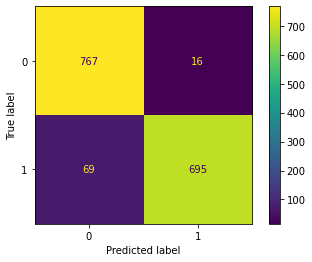

In [12]:
classifier, labels = clf_pred(X_train_feats, y_train, X_test_feats, y_test)

## Most informative features

This function finds the most informative words for the model and saves the output.

In [13]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):
    '''
    I found this function here:
    https://stackoverflow.com/questions/26976362/how-to-get-most-informative-features-for-scikit-learn-classifier-for-different-c
    And adapted it for my purposes.
    '''
    # get the labels
    class_labels = classifier.classes_
    # get the features
    feature_names = vectorizer.get_feature_names_out()
    # sort the features according to the model's coefficients 
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    # print the most informative features for non-depression
    print('most informative features for non-depression')
    # make them into a dataframe
    coefs = []
    feats = []
    for coef, feat in topn_class1:
        coefs.append(coef)
        feats.append(feat)
    features_non_depression = pd.DataFrame(coefs, feats)
    features_non_depression.reset_index(inplace=True)
    features_non_depression.columns = ['word','value']
    print(features_non_depression)
    # save 
    features_non_depression.to_csv('../out/features_non_depression.csv', index=False)

    print('') # for a bit of space
    
    # do the same for depression
    print('most informative features for depression')
    coefs = []
    feats = []
    for coef, feat in reversed(topn_class2):
        coefs.append(coef)
        feats.append(feat)
    features_depression = pd.DataFrame(coefs, feats)
    features_depression.reset_index(inplace=True)
    features_depression.columns = ['word','value']
    print(features_depression)
    features_depression.to_csv('../out/features_depression.csv', index=False)
        

In [14]:
most_informative_feature_for_binary_classification(vectorizer, classifier)

most informative features for non-depression
    word     value
0  sleep -0.888881
1   work -0.604568
2  today -0.571062
3    got -0.539824
4   find -0.474707
5     ha -0.387235
6     go -0.312104
7   well -0.281418
8    see -0.205509
9  again -0.200370

most informative features for depression
         word      value
0  depression  13.316644
1     anxiety   5.715284
2         and   3.719885
3        life   3.577879
4      myself   3.439551
5          me   3.294675
6     anymore   2.937231
7        feel   2.783699
8          if   2.716638
9      anyone   2.698831


# Sentiment analysis

This function processes the data again.

In [15]:
def reload_and_process():
    filepath = os.path.join('../in/depression_dataset_reddit_cleaned.csv')
    # read data as pandas data frame
    data = pd.read_csv(filepath)
    # remove unwanted characters 
    for post in data:
        post = text_preprocessing(post)
    # remove stopwords
    data['clean_text'] = data['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_corpus)]))
    # split the data
    depression = data[data['is_depression'] == 1]
    non_depression = data[data['is_depression'] == 0]

    return depression, non_depression

In [16]:
depression, non_depression = reload_and_process()

This function performs sentiment analysis with *Vader*.

In [17]:
def sent_analysis(data):
    sents = []
    scores = []
    for post in data['clean_text']:
        # get the sentiment of each post
        sent = sent_analyzer.polarity_scores(post)
        # if the sentiment is less than 0.05 it is negative - add that to a column and the sentiment score to another
        if sent['compound'] <= -0.05:
            sents.append('negative')
            scores.append(sent['compound'])
        # do the same for the positive posts
        elif sent['compound'] >= 0.05:
            sents.append('positive')
            scores.append(sent['compound'])
        # do the same for the neutral posts 
        else:
            sents.append('neutral')
            scores.append(sent['compound'])
    
    # add the sentiments to the dataframe
    data['sentiment'] = sents
    # add the scores to the dataframe
    data['sent_scores'] = scores
    
    # print the value counts of each sentiment
    print(data['sentiment'].value_counts())
    df = pd.DataFrame(data['sentiment'].value_counts())
    df.reset_index(inplace=True)
    
    print('') # for a bit of space
    
    # print descriptive statistics
    print(data['sent_scores'].describe())
    
    return df

In [18]:
depression_sents = sent_analysis(depression)

sentiment
negative    2514
positive    1174
neutral      143
Name: count, dtype: int64

count    3831.000000
mean       -0.270011
std         0.681908
min        -0.999400
25%        -0.872000
50%        -0.571900
75%         0.340000
max         0.999100
Name: sent_scores, dtype: float64


In [19]:
non_depression_sents = sent_analysis(non_depression)

sentiment
negative    1464
positive    1403
neutral     1033
Name: count, dtype: int64

count    3900.000000
mean       -0.003305
std         0.423957
min        -0.924600
25%        -0.340000
50%         0.000000
75%         0.340000
max         0.961200
Name: sent_scores, dtype: float64


Save outputs.

In [20]:
depression_sents.to_csv('../out/sents_depression.csv', index=False)
non_depression_sents.to_csv('../out/sents_non_depression.csv', index=False)

Playing around with Vader.

In [21]:
sent_analyzer.polarity_scores('''I'm very happy''')

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [22]:
sent_analyzer.polarity_scores('''I'm very sad''')

{'neg': 0.629, 'neu': 0.371, 'pos': 0.0, 'compound': -0.5256}

In [23]:
sent_analyzer.polarity_scores('''I'm very sad and angry''')

{'neg': 0.699, 'neu': 0.301, 'pos': 0.0, 'compound': -0.788}

In [24]:
sent_analyzer.polarity_scores('''I'm very sad and angry and hurt''')

{'neg': 0.721, 'neu': 0.279, 'pos': 0.0, 'compound': -0.8849}

In [25]:
sent_analyzer.polarity_scores('depression')

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5719}